Microbial ecologists have long considered the 515F SSU rRNA gene PCR primer to be "universal." That is, the 515F primer is thought to amplify Eukarya, Archaea, and Bacteria. Indeed the target of the 515F primer is well conserved across each domain, however, the there are some differences in the primer target between domains that should be considered when evaluating 515F for use in a microbial diversity studies.

To make matters more complicated the 515F primer has changed from its inception to account for new sequence information and it's not clear from the literature which 515F version is most effective. *In this post, we'll take a look at tbe 515F primer target across a broad diversity of SSU rRNA genes*. In subsequent posts we'll evaluate different 515F versions and we'll also evaluate reverse primers that can be paired with 515F. While there are excellent tools avaliable for SSU rRNA gene PCR primer analysis (see [PrimerProspector](http://pprospector.sourceforge.net/), [TestPrime](http://www.arb-silva.de/search/testprime/)), most tools focus on nucleotide frequecies in aligments. In this post, we'll evaluate 515F by looking at the distribution of 515F target oligos.

We'll use the 99% OTU seed sequences for the GreenGenes database as reference. You can download the GreenGenes files from [here](https://rnacentral.org/expert-database/greengenes). This analysis will focus on Archaea and Bacteria.

First we need to import some python functions and modules as well as load some extensions for the IPython notebook.

In [1]:
%matplotlib inline
%load_ext rpy2.ipython
import matplotlib.pyplot as plt
import re
from align import aligner
from skbio import DNA, parse_fasta, SequenceCollection
import pandas as pd

Eventually we'll want to explore target sites by their taxonomic affiliation so we need to get the taxonomic information from the GreenGenes files we downloaded (above). The following code is a quick and dirty way to populate a [pandas](http://pandas.pydata.org/) DataFrame with the taxonomic annotations for the gene sequences we'll be working with.

In [2]:
def parse_tax(line):
    id, tax_str = line.split("\t")
    k, p, c, o, f, g, s = tax_str.rstrip().split(";")
    tax_dict = {"kingdom" : k.split("__")[1],
                "phylum"  : p.split("__")[1],
                "class"   : c.split("__")[1],
                "family"  : f.split("__")[1],
                "order"   : o.split("__")[1],
                "genus"   : g.split("__")[1],
                "species" : s.split("__")[1],
                "id"      : id}
    return tax_dict
    

df = pd.DataFrame.from_records([parse_tax(line) for line in 
                                open("data/gg_13_5_otus/taxonomy/99_otu_taxonomy.txt")])

df.set_index("id", inplace=True)

Now that we have the taxonomy for each sequence, let's get the 515F target site. To do this we just align one combination of the degenerate 515F primer to each SSU rRNA gene sequence. We then pull out the aligned region from the SSU rRNA gene sequence -- this is the 515F target! I'm using the ```glocal``` method for the ```Python``` [aligner](https://github.com/brentp/align) package for the alignment and I'm using [scikit-bio](http://scikit-bio.org/) to parse and manage the SSU rRNA gene sequenes.

In [3]:
fn = "data/gg_13_5_otus/rep_set/99_otus.fasta"
degens = DNA.iupac_degenerate_characters()
seqs = SequenceCollection.from_fasta_records([(n, s) for n, s in parse_fasta(fn) 
                                              if not any(i in s for i in degens)], 
                                             DNA)

ids = [seq[0] for seq in seqs.iteritems()]

In [4]:
%%time
F515 = DNA("GTGCCAGCCGCCGCGGTAA") #GTGCCAGCMGCCGCGGTAA  M = [CA]

primer_targets_515 = [aligner(F515.sequence, 
                              seq[1].sequence,
                              method = "glocal")[1] 
                      for seq in seqs.iteritems()]

CPU times: user 20min 29s, sys: 112 ms, total: 20min 30s
Wall time: 20min 31s


Now we can join our target and taxonomy information into a single DataFrame. Each row represents one target from one gene. Specifically, each row has the target sequence and corresponding taxonomic information.

In [5]:
df_targets = df.join(pd.Series(primer_targets_515, index=ids, name = "515F"), how = "left")
df_targets.dropna(axis=0, subset=["515F"], inplace=True)

I love [pandas](http://pandas.pydata.org/) but I think for this application it will be best to use the (mind-blowingly amazing) R package [dplyR](http://cran.rstudio.com/web/packages/dplyr/vignettes/introduction.html). So, we need to push our pandas DataFrame into  an R session. I'm using the ```rmagic``` functions from [IPython](http://ipython.org/)/[rpy2](http://rpy.sourceforge.net/) to move from Python to R.

In [6]:
%R -i df_targets

In [7]:
%%R
library(dplyr)
library(ggplot2)
library(ggthemes)
library(magrittr)
# <!-- collapse=True -->


Attaching package: ‘dplyr’

The following object is masked from ‘package:stats’:

    filter

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Ok, now we can make some figures! Let's first look at the ten most abundant archaeal and bacterial 515F targets. You can see below that the bacterial 515F targets are dominated by a single sequence, and, that although the nineteen targets are similar in sequence there is little overlap in target representation between Archaea and Bacteria.

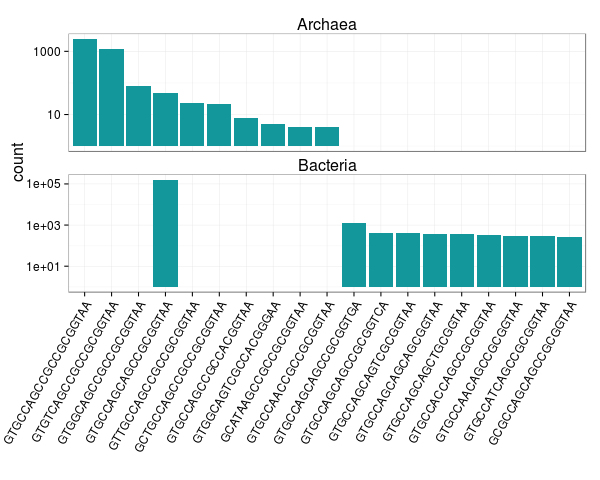

In [8]:
#| code-fold: true
#| fig-align: center
%%R -w 600
d = df_targets %>%
    group_by(kingdom, X515F) %>%
    summarize(count = n()) %>%
    filter(rank(desc(count), ties.method = "random") <= 10) %>%
    arrange(desc(count), kingdom) %>%
    mutate(X515F = factor(X515F, levels = unique(.$X515F)))

p = ggplot(d, aes(x = X515F, y = count))

p = p + facet_wrap(~kingdom, ncol = 1, scales = "free_y")

p = p + geom_bar(stat = "identity", fill = "#14979B")

p = p + labs(x = "")

p = p + scale_y_log10()

p = p + theme_bw()

p = p + theme(axis.text.x = element_text(angle = 60, hjust = 1, size = 12),
              axis.text.y = element_text(size = 12),
              axis.title = element_text(size = 16),
              strip.background = element_blank(),
              strip.text = element_text(size = 16))
                                    
p
# <!-- collapse=True -->

If we dig a little deeper into to archaeal 515F targets, we see some interesting trends among phyla. There are very few Nanoarchaea sequences in the reference database but they all have the same 515F target sequence which appears to be unique to Nanoarchaea. Also, there are a couple relatively abundant 515F target sequences with insertions. Eight of the ten most abundant archaeal 515F targets are identical over the last six nucleotides at the 3' end of the 515F primer.

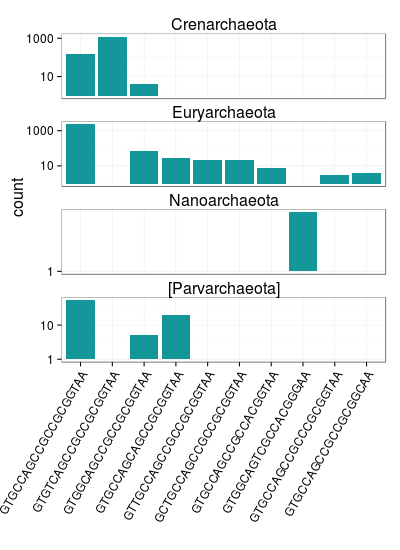

In [9]:
#| code-fold: true
#| fig-align: center
%%R -h 550 -w 400
d = df_targets %>%
    filter(kingdom == "Archaea", phylum != "") %>%
    {
        top10 = group_by(., X515F) %>%
            summarize(count = n()) %>%
            filter(rank(desc(count), ties.method = "random") <= 10) %>%
            extract2("X515F") %>% 
            unique %>%
            as.character
        filter(., X515F %in% top10) 
    } %>%
    group_by(phylum, X515F) %>%
    summarize(count = n()) %>%
    {
        psort = group_by(., X515F) %>%
            summarize(S = sum(count)) %>%
            arrange(desc(S)) %>%
            extract2("X515F") %>% as.character
        mutate(., X515F = factor(X515F, levels = psort))
    }

p = ggplot(d, aes(x = X515F, y = count))

p = p + facet_wrap(~phylum, ncol = 1, scales = "free_y")

p = p + geom_bar(stat = "identity", fill = "#14979B")

p = p + labs(x = "")

p = p + scale_y_log10()

p = p + theme_bw()

p = p + theme(axis.text.x = element_text(angle = 60, hjust = 1, size = 12),
              axis.text.y = element_text(size = 12),
              axis.title = element_text(size = 16),
              strip.background = element_blank(),
              strip.text = element_text(size = 16))

p

The Bacteria appear to be dominated by a single target sequence (above). Let's get that sequence explicitly.

In [10]:
%%R
max.target = df_targets %>%
    filter(kingdom == "Bacteria") %>%
    group_by(X515F) %>%
    summarize(count = n()) %>%
    arrange(desc(count)) %>%
    filter(rank(desc(count)) == 1) %>%
    extract2("X515F") %>% as.character

paste("The most abundant target sequence among bacteria is", max.target)
# <!-- collapse=True -->

[1] "The most abundant target sequence among bacteria is GTGCCAGCAGCCGCGGTAA"


There are some phyla, however, that are not as dominated by the most abundant bacterial 515F target. Here is a histogram of representation (percentages of total targets) within phylum for the most abundant bacterial 515F target. You can see that there are nine phyla for which the most abundant 515F bacterial target represents less than 80% of total targets.

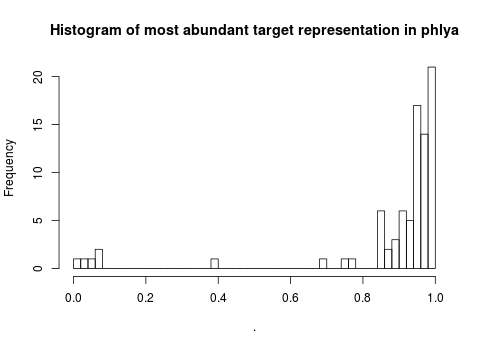

In [11]:
#| fig-align: center
%%R -h 350
df_targets %>%
    filter(kingdom == "Bacteria", phylum != "" ) %>%
    group_by(phylum, X515F) %>%
    summarize(count = n()) %>%
    group_by(phylum) %>%
    mutate(count.relative = count / sum(count)) %>%
    filter(X515F == max.target) %>%
    extract2("count.relative") %>% hist(breaks = 50,
                                        main = "Histogram of most abundant target representation in phlya")
# <!-- collapse=True -->

Let's see what the 515F targets look like for those nine phyla (above). The plot below shows the five most abundant 515F targets ranked by max representation within a phylum for the nine selected phyla. You can see that FCPU426, WS5, and GN01 515F targets are still dominated by the most abundant 515F target across all bacteria (GTGCCAGCAGCCGCGGTAA). The TM7 phylum 515F targets differ from the most abundant target at the 3' end of the 515F primer.

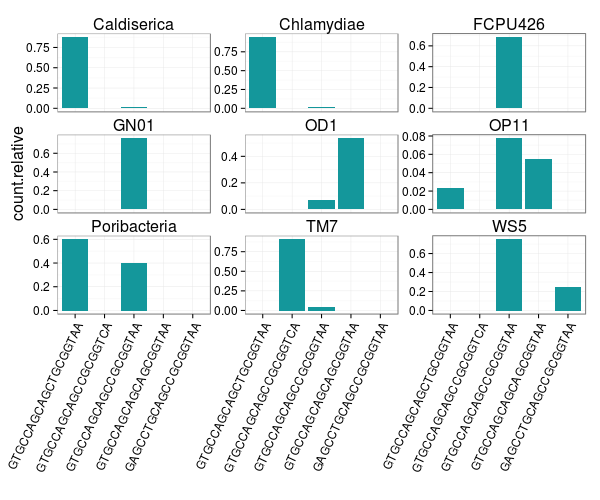

In [12]:
#| code-fold: true
#| fig-align: center
%%R -w 600 -h 500
d = df_targets %>%
    filter(kingdom == "Bacteria", phylum != "" ) %>%
    group_by(phylum, X515F) %>%
    summarize(count = n()) %>%
    group_by(phylum) %>%
    mutate(count.relative = count / sum(count)) %>%
    {
        keep = filter(., X515F == max.target, count.relative <= 0.80) %>%
            extract2("phylum") %>% 
            unique %>%
            as.character
        filter(., phylum %in% keep)
    } %>%
    {
        top = group_by(., X515F) %>%
            summarize(m = max(count.relative)) %>%
            filter(rank(desc(m), ties.method = "random") <= 5) %>%
            arrange(desc(m)) %>%
            extract2("X515F") %>% 
            unique %>%
            as.character
        filter(., X515F %in% top) %>% mutate(X515F = factor(X515F, levels = top))
    }

p = ggplot(d, aes(x = X515F, y = count.relative))

p = p + facet_wrap(~phylum, ncol = 3, scales = "free_y")

p = p + geom_bar(stat = "identity", fill = "#14979B")

p = p + labs(x = "")

p = p + theme_bw()

p = p + theme(axis.text.x = element_text(angle = 65, hjust = 1, size = 12),
              axis.text.y = element_text(size = 12),
              axis.title = element_text(size = 16),
              strip.background = element_blank(),
              strip.text = element_text(size = 16))

p
# <!-- collapse=True -->

I would guess that these nine phyla are the most likely to be missed by commonly used variants of 515F primers. 

**In the next post we'll test that hypothesis by evaluating how well the 515F primer matches the targets we've identified...**